In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .80)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(sampling_strategy=.90)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

0    649
1     62
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [9]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    649
1    584
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [10]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [11]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [12]:
print(training_split.shape)
print(test_split.shape)

(1233, 82184)
(89, 82184)


In [77]:
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())
features

array(['10000', '10001', '10008', ..., '99962', '99972', '9998'],
      dtype=object)

In [78]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [79]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [80]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [81]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [82]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [83]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( 5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [157]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .70 and self.f1_train > .70:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [158]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [159]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.2 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [160]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
bfore traning:  47.81832927818329
Epoch 1/60


2022-11-11 10:51:56.439815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6693 - tp: 2315.0000 - fp: 371.0000 - tn: 2846.0000 - fn: 633.0000 - precision: 0.8619 - recall: 0.7853

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8217962444592618
Recall TRAINING:  0.7852781414985657
89/89 [==============================] - 3s 24ms/step - loss: 0.6693 - tp: 2315.0000 - fp: 371.0000 - tn: 2846.0000 - fn: 633.0000 - precision: 0.8619 - recall: 0.7853



****** Early Stopping *******
39/39 [==============================] - 0s 3ms/step


2022-11-11 10:51:59.455332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.81640625
0.8475263584752636
error_rate: 0.0001236606987224139
1.0000000000000058
 =========== iteration ===========>: 1
bfore traning:  82.43309002433091
Epoch 1/60


2022-11-11 10:52:00.263729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6705 - tp: 4818.0000 - fp: 919.0000 - tn: 164.0000 - fn: 264.0000 - precision: 0.8398 - recall: 0.9481

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8906553433219584
Recall TRAINING:  0.9480519890785217
89/89 [==============================] - 3s 22ms/step - loss: 0.6705 - tp: 4818.0000 - fp: 919.0000 - tn: 164.0000 - fn: 264.0000 - precision: 0.8398 - recall: 0.9481



****** Early Stopping *******
39/39 [==============================] - 0s 3ms/step


2022-11-11 10:52:03.157058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6428178315905339
0.47364152473641524
error_rate: 0.00014659475409723962
0.9999999999999551
 =========== iteration ===========>: 2
bfore traning:  12.635847526358477
Epoch 1/60


2022-11-11 10:52:03.923059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 0.6642 - tp: 62.0000 - fp: 153.0000 - tn: 5233.0000 - fn: 717.0000 - precision: 0.2884 - recall: 0.0796
Epoch 2/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1802 - tp: 3.0000 - fp: 0.0000e+00 - tn: 5386.0000 - fn: 776.0000 - precision: 1.0000 - recall: 0.0039
Epoch 3/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1652 - tp: 2.0000 - fp: 0.0000e+00 - tn: 5386.0000 - fn: 777.0000 - precision: 1.0000 - recall: 0.0026
Epoch 4/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1601 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5386.0000 - fn: 779.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1577 - tp: 6.0000 - fp: 0.0000e+00 - tn: 5386.0000 - fn: 773.0000 - precision: 1.0000 - recall: 0.0077
Epoch 6/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1512 - tp: 1.0000 - fp: 0.0000e+00 

2022-11-11 10:52:33.396046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.4204851752021563
0.6512570965125709
error_rate: 3.174471499036416e-05
0.9999999999999994
 =========== iteration ===========>: 3
bfore traning:  70.73803730738038
Epoch 1/60


2022-11-11 10:52:34.147486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6648 - tp: 4244.0000 - fp: 833.0000 - tn: 971.0000 - fn: 117.0000 - precision: 0.8359 - recall: 0.9732

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8993431070935025
Recall TRAINING:  0.9731712937355042
89/89 [==============================] - 3s 22ms/step - loss: 0.6648 - tp: 4244.0000 - fp: 833.0000 - tn: 971.0000 - fn: 117.0000 - precision: 0.8359 - recall: 0.9732



****** Early Stopping *******
39/39 [==============================] - 0s 4ms/step


2022-11-11 10:52:36.959837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6428178315905339
0.47364152473641524
error_rate: 0.00022705708326612315
0.9999999999999772
 =========== iteration ===========>: 4
bfore traning:  8.6455798864558
Epoch 1/60


2022-11-11 10:52:37.773294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 0.6618 - tp: 178.0000 - fp: 106.0000 - tn: 5526.0000 - fn: 355.0000 - precision: 0.6268 - recall: 0.3340
Epoch 2/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1672 - tp: 11.0000 - fp: 0.0000e+00 - tn: 5632.0000 - fn: 522.0000 - precision: 1.0000 - recall: 0.0206
Epoch 3/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1514 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5632.0000 - fn: 533.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5632.0000 - fn: 533.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1344 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5632.0000 - fn: 533.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1286 - tp

2022-11-11 10:52:55.712695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.1282051282051282
0.5587996755879967
error_rate: 2.174483321008233e-05
1.0000000000000049
 =========== iteration ===========>: 5
bfore traning:  67.20194647201947
Epoch 1/60


2022-11-11 10:52:56.542694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6582 - tp: 4015.0000 - fp: 1775.0000 - tn: 247.0000 - fn: 128.0000 - precision: 0.6934 - recall: 0.9691

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8084164085291426
Recall TRAINING:  0.969104528427124
89/89 [==============================] - 3s 23ms/step - loss: 0.6582 - tp: 4015.0000 - fp: 1775.0000 - tn: 247.0000 - fn: 128.0000 - precision: 0.6934 - recall: 0.9691



****** Early Stopping *******
39/39 [==============================] - 0s 4ms/step


2022-11-11 10:52:59.431412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6431718061674009
0.4744525547445255
error_rate: 0.00025314389298742505
0.9999999999999782
 =========== iteration ===========>: 6
bfore traning:  7.948094079480941
Epoch 1/60


2022-11-11 10:53:00.281440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 0.6645 - tp: 11.0000 - fp: 121.0000 - tn: 5554.0000 - fn: 479.0000 - precision: 0.0833 - recall: 0.0224
Epoch 2/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1789 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5675.0000 - fn: 490.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
89/89 [==============================] - 1s 14ms/step - loss: 0.1587 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5675.0000 - fn: 490.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
89/89 [==============================] - 1s 12ms/step - loss: 0.1449 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5675.0000 - fn: 490.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1363 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5675.0000 - fn: 490.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
89/89 [==============================] - 1s 11ms/step - loss: 0

2022-11-11 10:54:05.824143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.4712041884816754
0.6723438767234388
error_rate: 2.467843396768311e-05
1.0000000000000058
 =========== iteration ===========>: 7
bfore traning:  69.97566909975669
Epoch 1/60


2022-11-11 10:54:06.621842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6617 - tp: 4299.0000 - fp: 1847.0000 - tn: 4.0000 - fn: 15.0000 - precision: 0.6995 - recall: 0.9965

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8219885160792348
Recall TRAINING:  0.9965229034423828
89/89 [==============================] - 3s 24ms/step - loss: 0.6617 - tp: 4299.0000 - fp: 1847.0000 - tn: 4.0000 - fn: 15.0000 - precision: 0.6995 - recall: 0.9965



****** Early Stopping *******
39/39 [==============================] - 0s 4ms/step


2022-11-11 10:54:09.617606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6428178315905339
0.47364152473641524
error_rate: 0.0002429999067345097
1.0000000000000027
 =========== iteration ===========>: 8
bfore traning:  7.477696674776967
Epoch 1/60


2022-11-11 10:54:10.421633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 24ms/step - loss: 0.6436 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5704.0000 - fn: 461.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1577 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5704.0000 - fn: 461.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1412 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5704.0000 - fn: 461.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1354 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5704.0000 - fn: 461.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1273 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5704.0000 - fn: 461.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
89/89 [==============================] - 1s 12ms/s

2022-11-11 10:55:16.964248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_4137/1992033442.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)


nan
0.5263584752635847
error_rate: 6.268342060478261e-05
0.9999999999999984
 =========== iteration ===========>: 9
bfore traning:  80.32441200324412
Epoch 1/60


2022-11-11 10:55:17.790537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6510 - tp: 4947.0000 - fp: 1211.0000 - tn: 2.0000 - fn: 5.0000 - precision: 0.8033 - recall: 0.9990

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8905490876922642
Recall TRAINING:  0.9989903569221497
89/89 [==============================] - 3s 24ms/step - loss: 0.6510 - tp: 4947.0000 - fp: 1211.0000 - tn: 2.0000 - fn: 5.0000 - precision: 0.8033 - recall: 0.9990



****** Early Stopping *******
39/39 [==============================] - 0s 4ms/step


2022-11-11 10:55:20.778864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6428178315905339
0.47364152473641524
error_rate: 0.00016157409582728572
1.0000000000000062
 =========== iteration ===========>: 10
bfore traning:  11.338199513381996
Epoch 1/60


2022-11-11 10:55:21.554157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 23ms/step - loss: 0.6471 - tp: 15.0000 - fp: 86.0000 - tn: 5380.0000 - fn: 684.0000 - precision: 0.1485 - recall: 0.0215
Epoch 2/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1699 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5466.0000 - fn: 699.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1590 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5466.0000 - fn: 699.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1527 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5466.0000 - fn: 699.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
89/89 [==============================] - 1s 13ms/step - loss: 0.1491 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5466.0000 - fn: 699.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
89/89 [==============================] - 1s 12ms/step - loss: 0.

2022-11-11 10:56:21.729074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6636155606407322
0.7615571776155717
error_rate: 3.079801018572875e-05
1.0000000000000129
 =========== iteration ===========>: 11
bfore traning:  74.27412814274128
Epoch 1/60


2022-11-11 10:56:22.548103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 0.6952 - tp: 4230.0000 - fp: 525.0000 - tn: 1061.0000 - fn: 349.0000 - precision: 0.8896 - recall: 0.9238

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9063638516560926
Recall TRAINING:  0.9237825274467468
89/89 [==============================] - 3s 25ms/step - loss: 0.6952 - tp: 4230.0000 - fp: 525.0000 - tn: 1061.0000 - fn: 349.0000 - precision: 0.8896 - recall: 0.9238



****** Early Stopping *******
39/39 [==============================] - 0s 3ms/step
0.42876344086021506
0.31062449310624496
error_rate: 0.00011054060001555545
1.0000000000000098


2022-11-11 10:56:25.689336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [161]:
alphas

[1.7995690750306808,
 1.7655383894871992,
 2.0715505116517234,
 1.6780164042196706,
 2.1472225274279397,
 1.6562598615973685,
 2.121911227139861,
 1.6644412937992812,
 1.9354701768144975,
 1.7460770271349089,
 2.07760593518934,
 1.8220034273647372]

In [162]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [163]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [193]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    return score

In [200]:
f1_test = []
for i in range(1,13):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
3/3 [==============================] - 0s 7ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 0
3/3 [==============================] - 0s 4ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 0
3/3 [==============================] - 0s 3ms/step
*********: 1
3/3 [==============================] - 0s 2ms/step
*********: 2
3/3 [==============================] - 0s 2ms/step
*********: 3
3/3 [==============================] - 0s 2ms/step
*********: 0
3/3 [==============================] - 0s 2ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step
*********: 2
3/3 [==============================] - 0s 3ms/step
*********: 3
3/3 [==============================] - 0s 3ms/step
*********: 4
3/3 [==============================] - 0s 2ms/step
*********: 0
3/3 [======================

*********: 0
3/3 [==============================] - 0s 8ms/step
*********: 1
3/3 [==============================] - 0s 3ms/step


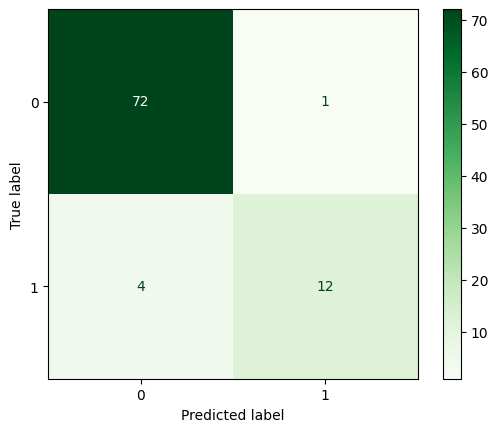

In [209]:
data = some_pred(test_split, 2)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')
# plt.plot(f1_test)

In [206]:
f1_train = []
for i in range(1,13):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
39/39 [==============================] - 0s 3ms/step
*********: 0
39/39 [==============================] - 0s 2ms/step
*********: 1
39/39 [==============================] - 0s 2ms/step
*********: 0
39/39 [==============================] - 0s 2ms/step
*********: 1
39/39 [==============================] - 0s 2ms/step
*********: 2
39/39 [==============================] - 0s 2ms/step
*********: 0
39/39 [==============================] - 0s 2ms/step
*********: 1
39/39 [==============================] - 0s 2ms/step
*********: 2
39/39 [==============================] - 0s 2ms/step
*********: 3
39/39 [==============================] - 0s 2ms/step
*********: 0
39/39 [==============================] - 0s 2ms/step
*********: 1
39/39 [==============================] - 0s 2ms/step
*********: 2
39/39 [==============================] - 0s 2ms/step
*********: 3
39/39 [==============================] - 0s 2ms/step
*********: 4
39/39 [==============================] - 0s 2ms/step
*********:

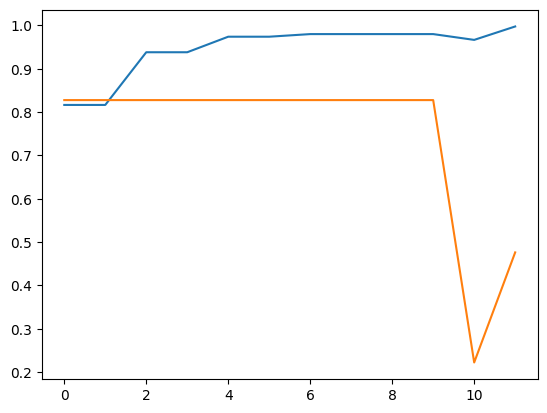

In [208]:
plt.plot(f1_train)
plt.plot(f1_test)

*********: 0
39/39 [==============================] - 0s 3ms/step
*********: 1
39/39 [==============================] - 0s 2ms/step


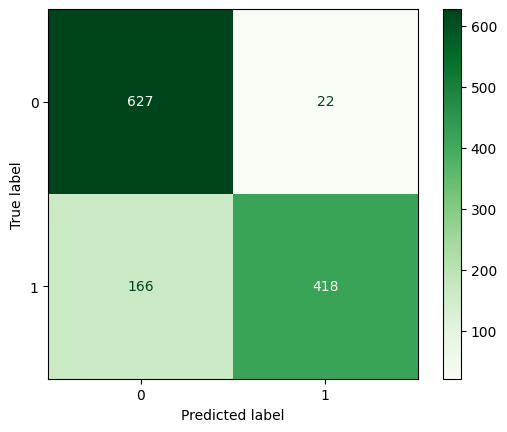

In [210]:
data = some_pred(training_split, 2)
ans = majority(data)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [211]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 2))

*********: 0
11/11 [==============================] - 0s 5ms/step
*********: 1
11/11 [==============================] - 0s 2ms/step


In [214]:
len(predicted_data)


350

In [213]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()